<a href="https://colab.research.google.com/github/BaharehAm/Investigating-the-effectiveness-of-Twitter-sentiment-in-cryptocurrency-close-price-prediction/blob/main/Cryptocurrency_Close_Price_Prediction_(LSTM_CNN_Att).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary librarires

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.pylab as plt
import os
from sklearn.preprocessing import MinMaxScaler
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, LSTM, Conv1D, MaxPooling1D, Flatten, concatenate, Dropout
from keras.models import Sequential
from keras.metrics import mean_squared_error
import tensorflow as tf
from datetime import datetime
from numpy.random import seed
tf.compat.v1.random.set_random_seed(1234)
import glob
from tensorflow.keras.utils import plot_model

In [38]:
pd.options.mode.chained_assignment = None  # default='warn'

# Data exploration

In [4]:
os.chdir("/content/drive/My Drive/Research/data/")
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

## read the csv files into a dictionary (this will load all CSV files, however, only one file for a single crypto will be used)
DFs = {}
for f in all_filenames:
  os.chdir("/content/drive/My Drive/Research/data/")
  DFs[f] = pd.read_csv(f)
  # period = (DFs[f]['Date'] >= '2021-01-01') & (DFs[f]['Date']  < '2022-01-01')
  DFs[f].drop(labels=["High","Open","Low","Volume","Currency"], axis=1, inplace=True)

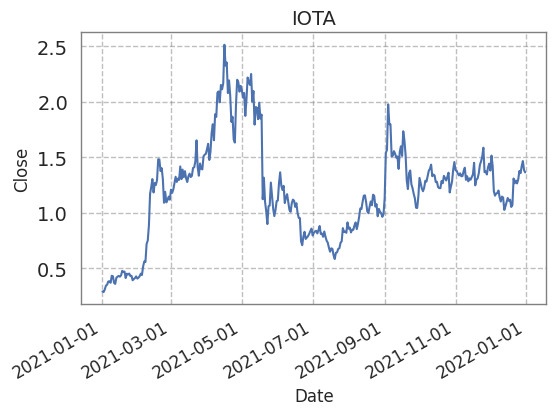

In [50]:
# os.chdir("/content/drive/My Drive/Research/Price/final_results_h7")

target = 'Close'  ## Close price to be predicted
crypto = 'IOTA.csv'  ## An example cryptocurrency
period = (DFs[crypto]['Date'] >= '2021-01-01') & (DFs[crypto]['Date']  < '2022-01-01')  ## One year of data (according to what hasbeen in the paper)
data = DFs[crypto].loc[period]
data.head()

fig, ax = plt.subplots(figsize=(6, 4))
ax.set_facecolor('w')  # Set background color to white
plt.title(crypto.replace('.csv', ''), fontsize = 14)
plt.ylabel(target, fontsize = 12)
plt.xlabel('Date', fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
ax.grid(True, linestyle='--', color='gray', alpha=0.5)
for spine in ax.spines.values():
    spine.set_edgecolor('gray')  # You can change the color to your preference
    spine.set_linewidth(1)        # You can change the width to your preference


data.set_index('Date', inplace = True)
data.index = pd.to_datetime(data.index).date
ax = data[target].plot()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.show()
# fig.savefig(crypto.replace('.csv', '')+ '_Closing_Price.jpg')

In [51]:
data.head()

,Close
2021-01-01,0.29086
2021-01-02,0.28561
2021-01-03,0.30916
2021-01-04,0.34354
2021-01-05,0.35228


In [52]:
# Resetting index and adding it as a column
data.reset_index(inplace=True)
data.rename(columns={'index': 'Date'}, inplace=True)
data.head()

,Date,Close
0,2021-01-01,0.29086
1,2021-01-02,0.28561
2,2021-01-03,0.30916
3,2021-01-04,0.34354
4,2021-01-05,0.35228


In [53]:
os.chdir("/content/drive/My Drive/Research/Price/sentiment_data/Majority_Sentiments")
df_sent = pd.read_csv(crypto.replace('.csv','')+'_Aggregated_Sentiments_new.csv', usecols=lambda column: column != 'Unnamed: 0')
df_sent

,date,Negative,Neutral,Positive,Sentiment_score
0,2021-01-01 00:00:00+00:00,402,456,121,-0.287028
1,2021-01-02 00:00:00+00:00,489,486,130,-0.324887
2,2021-01-03 00:00:00+00:00,551,617,121,-0.333592
3,2021-01-04 00:00:00+00:00,553,604,162,-0.296437
4,2021-01-05 00:00:00+00:00,443,580,187,-0.211570
...,...,...,...,...,...
360,2021-12-27 00:00:00+00:00,681,1110,311,-0.176023
361,2021-12-28 00:00:00+00:00,801,1704,671,-0.040932
362,2021-12-29 00:00:00+00:00,652,1439,579,-0.027341
363,2021-12-30 00:00:00+00:00,480,853,247,-0.147468


In [54]:
data['Sentiment_score'] = df_sent['Sentiment_score'].values
data

,Date,Close,Sentiment_score
0,2021-01-01,0.29086,-0.287028
1,2021-01-02,0.28561,-0.324887
2,2021-01-03,0.30916,-0.333592
3,2021-01-04,0.34354,-0.296437
4,2021-01-05,0.35228,-0.211570
...,...,...,...
360,2021-12-27,1.35748,-0.176023
361,2021-12-28,1.42096,-0.040932
362,2021-12-29,1.46657,-0.027341
363,2021-12-30,1.38442,-0.147468


In [55]:
## data split: 80% for training set, 20% for testing set, last 20% of the training set for validation set

train_valid_size = int(0.8*len(data))
valid_size = int(0.2*(0.8*len(data)))
train_size = train_valid_size - valid_size
test_size = len(data)-int(0.8*len(data))

print("size of the train_valid set: ", train_valid_size)
print("size of the train set: ", train_size)
print("size of the validation set: ", valid_size)
print("size of the test set: ", test_size)
print('total: ', train_size + valid_size + test_size)

size of the train_valid set:  292
size of the train set:  234
size of the validation set:  58
size of the test set:  73
total:  365


In [56]:
def prepare_input(data, train_size, valid_size, feature, h):
  train_set = data[feature][:train_size].values
  valid_set = data[feature][train_size:train_size+valid_size].values
  ## Feature Scaling
  sc = MinMaxScaler(feature_range = (0, 1))
  train_set_scaled = sc.fit_transform(train_set)
  ## Creating a data structure with h time-steps and 1 output
  X_train = []
  y_train = []
  for i in range(h, train_size):
    X_train.append(train_set_scaled[i-h:i])                         ## X1:(rt-h,...,rt-1) ==> y1:Ct   OR   X1:(St-h,...,St-1) ==> y1:rt
    y_train.append(train_set_scaled[i, 0])                          ## 0 --> to consider only 'returns' as the y_train
  X_train, y_train = np.array(X_train), np.array(y_train)           ## X_train.shape = (train_size-h, h, number of features)
  ## preparing the validation set for making predictions
  dataset_train = data[feature][:train_size]
  valid = data[feature][train_size:train_size+valid_size]
  dataset_train_valid = pd.concat((dataset_train, valid), axis = 0)
  valid_h = dataset_train_valid[len(dataset_train_valid)-len(valid)-h:].values  ## valid_h.shape = (valid_size + h , number of features)
  valid_h = sc.transform(valid_h)
  X_valid = []
  for i in range(h, valid_h.shape[0]):
    X_valid.append(valid_h[i-h:i])
  X_valid = np.array(X_valid)      ## X_valid.shape = (valid_size , h , number of features)
  y_valid = valid.iloc[:, 0:1]
  return X_train, y_train, X_valid, y_valid, train_set_scaled

In [57]:
input_tmp = prepare_input(data, train_size, valid_size, [target,'Sentiment_score'], 21) ## Only for exploring the input data


print("shape of X_train: ",  input_tmp[0].shape)
print("shape of y_train: ",  input_tmp[1].shape)
print("shape of X_valid: ",  input_tmp[2].shape)
print("shape of y_valid: ",  input_tmp[3].shape)

# input_tmp[2]


shape of X_train:  (213, 21, 2)
shape of y_train:  (213,)
shape of X_valid:  (58, 21, 2)
shape of y_valid:  (58, 1)


In [58]:
## X1:(Ct-21,...,Ct-1) --> Close price data
input_tmp[0][0:1,:,0:1]

array([[[0.00235525],
        [0.        ],
        [0.01056499],
        [0.02598853],
        [0.02990947],
        [0.0427041 ],
        [0.04355199],
        [0.03742833],
        [0.06579904],
        [0.0637623 ],
        [0.03699317],
        [0.03296008],
        [0.05794371],
        [0.062237  ],
        [0.06518891],
        [0.06225494],
        [0.06722116],
        [0.08550241],
        [0.08229927],
        [0.08266265],
        [0.05672795]]])

In [59]:
## X1:(St-21,...,St-1) --> Sentiment scores data
input_tmp[0][0:1,:,1:2]

array([[[0.26131768],
        [0.19132562],
        [0.17523223],
        [0.24392266],
        [0.40081878],
        [0.06327524],
        [0.00562609],
        [0.        ],
        [0.48689219],
        [0.48903116],
        [0.16620378],
        [0.11707709],
        [0.21950453],
        [0.29369072],
        [0.27152923],
        [0.27994203],
        [0.13287287],
        [0.34930106],
        [0.28143345],
        [0.26449168],
        [0.21930715]]])

In [ ]:
# input_tmp[0]              ### using both 'Close' and 'Sentiment_score' as the feature set
# input_tmp[0][:,:,0:1]     ### using only 'Close' as the feature set
# input_tmp[0][:,:,1:2]     ### using only 'Sentiment_score' as the feature set

# Models

The following figure and table show the the proposed hybrid model and its 20 versions. [Source](https://onlinelibrary.wiley.com/doi/abs/10.1111/exsy.13428)

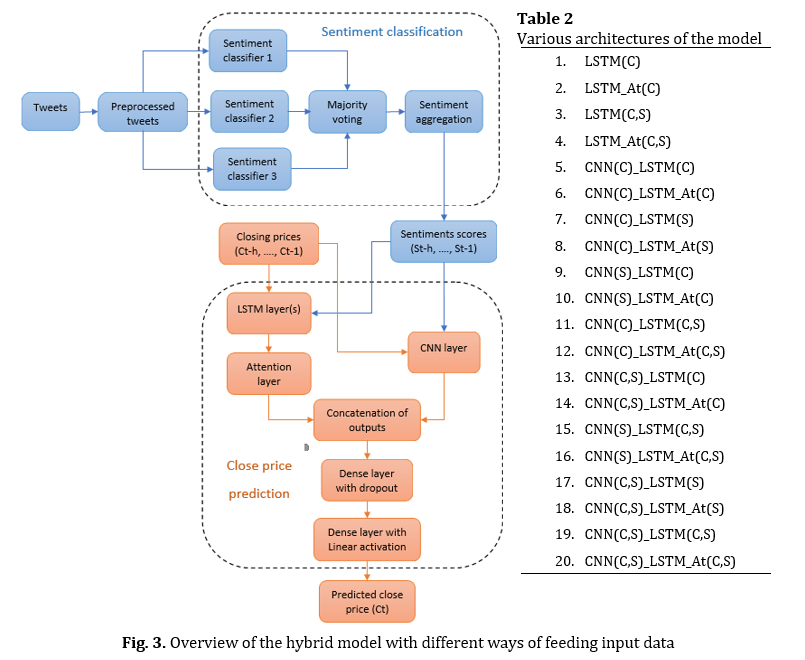

In [66]:
## attention layer
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x): #mapping of inputs to outputs
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

## Create single model (functional API)
def create_single_model(model_name, layer_number, hidden_units, dense_units, Dropout_layer, input_shape_lstm, activation):
    input = Input(shape=input_shape_lstm)
    if model_name in ["LSTM(C)", "LSTM(S)", "LSTM(C,S)"]:
      if layer_number == 1:
        x = LSTM(hidden_units, return_sequences=False, activation=activation)(input)
      elif layer_number == 2:
        x = LSTM(hidden_units, return_sequences=True, activation=activation)(input)
        x = LSTM(hidden_units, return_sequences=False, activation=activation)(x)
      else:
        x = LSTM(hidden_units, return_sequences=True, activation=activation)(input)
        x = LSTM(hidden_units, return_sequences=True, activation=activation)(x)
        x = LSTM(hidden_units, return_sequences=False, activation=activation)(x)
    else: ## ["LSTM_At(C), "LSTM_At(S), LSTM_At(C,S)"]
      if layer_number == 1:
        x = LSTM(hidden_units, return_sequences=True, activation=activation)(input)
        x = attention()(x)
      elif layer_number == 2:
        x = LSTM(hidden_units, return_sequences=True, activation=activation)(input)
        x = LSTM(hidden_units, return_sequences=True, activation=activation)(x)
        x = attention()(x)
      else:
        x = LSTM(hidden_units, return_sequences=True, activation=activation)(input)
        x = LSTM(hidden_units, return_sequences=True, activation=activation)(x)
        x = LSTM(hidden_units, return_sequences=True, activation=activation)(x)
        x = attention()(x)

    if Dropout_layer == True:
      z = Dense(dense_units, activation = activation)(x)
      z = Dropout(0.2)(z)
    else:
      z = Dense(dense_units, activation = activation)(x)

    z = Dense(1, activation='linear')(z)
    model = Model(inputs=input, outputs=z)
    model_plot = plot_model(model, show_shapes=True)
    return model, model_plot

In [67]:
## Create hybrid model  ===>   ["CNN(C)_LSTM(C)", "CNN(C)_LSTM(S)", "CNN(S)_LSTM(C)", "CNN(C,S)_LSTM(C,S)"]
def create_hybrid_model(model_name, layer_number, hidden_units, dense_units, Dropout_layer, input_shape_lstm, input_shape_cnn, activation, filters, kernel_size):
    b1_input = Input(shape=input_shape_lstm)
    if model_name in ["CNN(C)_LSTM(C)", "CNN(C)_LSTM(S)", "CNN(S)_LSTM(C)", "CNN(C,S)_LSTM(C,S)"]:
      if layer_number == 1:
          x = LSTM(hidden_units, return_sequences=False, activation=activation)(b1_input)
      elif layer_number == 2:
          x = LSTM(hidden_units, return_sequences=True, activation=activation)(b1_input)
          x = LSTM(hidden_units, return_sequences=False, activation=activation)(x)
      else:
          x = LSTM(hidden_units, return_sequences=True, activation=activation)(b1_input)
          x = LSTM(hidden_units, return_sequences=True, activation=activation)(x)
          x = LSTM(hidden_units, return_sequences=False, activation=activation)(x)
    else: ## ["CNN(C)_LSTM_At(C)", "CNN(C)_LSTM_At(S)", "CNN(S)_LSTM_At(C)", "CNN(C,S)_LSTM_At(C,S)"]
      if layer_number == 1:
        x = LSTM(hidden_units, return_sequences=True, activation=activation)(b1_input)
        x = attention()(x)
      elif layer_number == 2:
          x = LSTM(hidden_units, return_sequences=True, activation=activation)(b1_input)
          x = LSTM(hidden_units, return_sequences=True, activation=activation)(x)
          x = attention()(x)
      else:
          x = LSTM(hidden_units, return_sequences=True, activation=activation)(b1_input)
          x = LSTM(hidden_units, return_sequences=True, activation=activation)(x)
          x = LSTM(hidden_units, return_sequences=True, activation=activation)(x)
          x = attention()(x)

    b1_branch = Model(inputs=b1_input, outputs=x)
    b1_plot = plot_model(b1_branch, show_shapes=True)

    b2_input = Input(shape=input_shape_cnn)
    y = Conv1D(filters=filters, kernel_size=kernel_size, activation=activation)(b2_input)
    y = MaxPooling1D()(y)
    y = Flatten()(y)
    b2_branch = Model(inputs=b2_input, outputs=y)
    b2_plot = plot_model(b2_branch, show_shapes=True)

    combined = concatenate([b1_branch.output, b2_branch.output])

    if Dropout_layer == True:
      z = Dense(dense_units, activation = activation)(combined)
      z = Dropout(0.2)(z)
    else:
      z = Dense(dense_units, activation = activation)(combined)

    z = Dense(1, activation = 'linear')(z)

    model = Model(inputs=[b1_branch.input, b2_branch.input], outputs=z)
    model_plot = plot_model(model, show_shapes=True)
    return model, model_plot

In [ ]:
# create_hybrid_attention_model("CNN_LSTM_attention", 2, 50, 64, True, (21, 1), 'tanh', 64, 2)[1]
# create_single_model("LSTM", 2, 50, 64, True, (21, 2), 'tanh')[1]

# Experiments

In [61]:
def model_evaluation(Tuning, model_name, layer_number, hidden_units, dense_units, Dropout_layer, input_shape_lstm, input_shape_cnn, activation, loss, optimizer, epochs, batch_size, filters, kernel_size):
  if model_name in ["LSTM(C)", "LSTM_At(C)", "LSTM(S)", "LSTM_At(S)", "LSTM(C,S)", "LSTM_At(C,S)"]:
    model = create_single_model(model_name, layer_number, hidden_units, dense_units, Dropout_layer, input_shape_lstm, activation)[0]  #[0]: because we want only the model which is the first output of the function
    model.compile(loss=loss, optimizer=optimizer)
    if model_name in ["LSTM(C)", "LSTM_At(C)"]:
      x_tr = inputs[0][:,:,0:1]
      x_ev = inputs[2][:,:,0:1]
    elif model_name in ["LSTM(S)", "LSTM_At(S)"]:
      x_tr = inputs[0][:,:,1:2]
      x_ev = inputs[2][:,:,1:2]
    else: ## ["LSTM(C,S)", "LSTM_At(C,S)"]
      x_tr = inputs[0][:,:,0:2]
      x_ev = inputs[2][:,:,0:2]
  else: ## ["CNN(C)_LSTM(C)", "CNN(C)_LSTM(S)", "CNN(S)_LSTM(C)", "CNN(C,S)_LSTM(C,S)", "CNN(C)_LSTM_At(C)", "CNN(C)_LSTM_At(S)", "CNN(S)_LSTM_At(C)", "CNN(C,S)_LSTM_At(C,S)"]
    model = create_hybrid_model(model_name, layer_number, hidden_units, dense_units, Dropout_layer, input_shape_lstm, input_shape_cnn, activation, filters, kernel_size)[0]   #[0]: because we want only the model which is the first output of the function
    model.compile(loss=loss, optimizer=optimizer)
    if model_name in ["CNN(C)_LSTM(C)", "CNN(C)_LSTM_At(C)"]:
      x_tr = [inputs[0][:,:,0:1], inputs[0][:,:,0:1]]
      x_ev = [inputs[2][:,:,0:1], inputs[2][:,:,0:1]]
    elif model_name in ["CNN(C)_LSTM(S)", "CNN(C)_LSTM_At(S)"]:
      x_tr = [inputs[0][:,:,1:2], inputs[0][:,:,0:1]]
      x_ev = [inputs[2][:,:,1:2], inputs[2][:,:,0:1]]
    elif model_name in ["CNN(S)_LSTM(C)", "CNN(S)_LSTM_At(C)"]:
      x_tr = [inputs[0][:,:,0:1], inputs[0][:,:,1:2]]
      x_ev = [inputs[2][:,:,0:1], inputs[2][:,:,1:2]]
    elif model_name in ["CNN(C,S)_LSTM(C)", "CNN(C,S)_LSTM_At(C)"]:
      x_tr = [inputs[0][:,:,0:1], inputs[0][:,:,0:2]]
      x_ev = [inputs[2][:,:,0:1], inputs[2][:,:,0:2]]
    elif model_name in ["CNN(C)_LSTM(C,S)", "CNN(C)_LSTM_At(C,S)"]:
      x_tr = [inputs[0][:,:,0:2], inputs[0][:,:,0:1]]
      x_ev = [inputs[2][:,:,0:2], inputs[2][:,:,0:1]]
    elif model_name in ["CNN(C,S)_LSTM(S)", "CNN(C,S)_LSTM_At(S)"]:
      x_tr = [inputs[0][:,:,1:2], inputs[0][:,:,0:2]]
      x_ev = [inputs[2][:,:,1:2], inputs[2][:,:,0:2]]
    elif model_name in ["CNN(S)_LSTM(C,S)", "CNN(S)_LSTM_At(C,S)"]:
      x_tr = [inputs[0][:,:,0:2], inputs[0][:,:,1:2]]
      x_ev = [inputs[2][:,:,0:2], inputs[2][:,:,1:2]]
    else: ## ["CNN(C,S)_LSTM(C,S)", "CNN(C,S)_LSTM_At(C,S)"]:
      x_tr = [inputs[0][:,:,0:2], inputs[0][:,:,0:2]]
      x_ev = [inputs[2][:,:,0:2], inputs[2][:,:,0:2]]

  model_fit = model.fit(x_tr , y=inputs[1], epochs = epochs, batch_size = batch_size, verbose=0)
  predicted = model.predict(x_ev)
  sc2 = MinMaxScaler(feature_range = (0, 1))
  if Tuning==True:
    # print("Tuning")
    just_to_fit = data.iloc[train_size:train_valid_size, 1].values
    just_to_fit = just_to_fit.reshape(valid_size,1)
  else:
    just_to_fit = data.iloc[train_valid_size:train_valid_size+test_size, 1].values
    just_to_fit = just_to_fit.reshape(test_size,1)
    # print("Testing")

  just_to_inverse = sc2.fit_transform(just_to_fit)
  predicted_value = sc2.inverse_transform(predicted)
  predicted_value = predicted_value.reshape(-1)
  RMSE = np.sqrt(mean_squared_error(inputs[3][target].values, predicted_value))
  return RMSE, predicted_value

In [71]:
## Fixed parameters and hyper-parameters (no tuning)
loss='mse'
optimizer='adam'
epochs = 25
feature = [target, 'Sentiment_score']
h = 7  ## this is the size of lookback period. it can be anything (one week: h=7, two weeks: h=14, etc.)
num_runs = 10  ## For the robustness and reducing the effect of randomness, the average of multiple runs can be calculated for the RMSE
## (in the paper, the average of 30 runs were reported)

In [ ]:
# ### Hyper-parameter tuning - hybrid model:

# seed(1)
# tf.random.set_seed(1)


# inputs = prepare_input(data, train_size, valid_size, feature, h)
# input_shape_lstm = (inputs[0].shape[1], inputs[0].shape[2]-1)
# input_shape_cnn = (inputs[0].shape[1], inputs[0].shape[2]-1)
# print(input_shape_lstm, input_shape_cnn)

# # layer_numbers = [1, 2, 3]
# # hidden_units_set = [50, 100]
# # dense_units_set = [64, 128]
# # filters_set = [32, 64]
# # kernel_size_set = [2, 3, 4]
# # activations = ['tanh', 'relu']                  # tanh is better than relu
# # epochs_set = [25]
# # batch_sizes = [16, 32]

# layer_numbers = [1]
# hidden_units_set = [50]
# dense_units_set = [64]
# filters_set = [32]
# kernel_size_set = [2]
# activations = ['tanh']                  # tanh is better than relu
# epochs_set = [25]
# batch_sizes = [16]

# model_names = [
#                "CNN(C)_LSTM_At(C)"
#                ]

# num_runs_tun = 1
# j = 0
# tun_results = []
# for model_name in model_names:
#   for layer_number in layer_numbers:
#     for hidden_units in hidden_units_set:
#       for dense_units in dense_units_set:
#         for activation in activations:
#           for epochs in epochs_set:
#             for batch_size in batch_sizes:
#               for filters in filters_set:
#                 for kernel_size in kernel_size_set:
#                   RMSEs_tun = []
#                   j += 1
#                   for i in tf.range(num_runs_tun):
#                     RMSE_tun = model_evaluation(True, model_name, layer_number, hidden_units, dense_units, True, input_shape_lstm,
#                                                 input_shape_cnn, activation, loss, optimizer, epochs, batch_size, filters, kernel_size)[0]

#                     RMSEs_tun.append(RMSE_tun)
#                   AVG_RMSE_tun = np.mean(RMSEs_tun)
#                   result = [model_name, layer_number, hidden_units, dense_units, activation,
#                             epochs, batch_size, filters, kernel_size, AVG_RMSE_tun]
#                   tun_results.append(result)
#                   print(j)

# tun_results_df = pd.DataFrame(tun_results, columns = ["model_name", "layer_number", "hidden_units", "dense_units",
#                                                       "activation", "epochs", "batch_size", "filters", "kernel_size", "RMSE"])
# tun_results_df = tun_results_df.sort_values('RMSE')

# os.chdir("/content/drive/My Drive/Research/Tuning_Results/returns")   ## Save the tuning results in the Google Drive
# tun_results_df.to_csv(model_name+'_'+crypto)

# tun_results_df

In [63]:
## Tunned parameters for close prices:
os.chdir("/content/drive/My Drive/Research/Price/Tuning_Results")
tuning_results = pd.read_csv('CNN_LSTM_attention_'+ crypto)  ## Load the optimal parameters from the Google Drive
opt_params = tuning_results.iloc[0:1, :]
opt_params

,Unnamed: 0,model_name,layer_number,hidden_units,dense_units,activation,epochs,batch_size,filters,kernel_size,RMSE
0,153,CNN_LSTM_attention,2,100,64,tanh,25,32,64,2,0.184867


In [72]:
### Use the optimal hyper-parameters to test the models on test set:

os.chdir("/content/drive/My Drive/Research/Price/final_results_h7")  ## to save the results in Google drive
print(crypto + '\n')
seed(1)
tf.random.set_seed(1)

model_names = [
               "LSTM(C)", "LSTM_At(C)",                           # Model 1
               "LSTM(S)", "LSTM_At(S)",                           # Model 2
               "LSTM(C,S)", "LSTM_At(C,S)",                       # Model 3
               "CNN(C)_LSTM(C)", "CNN(C)_LSTM_At(C)",             # Model 4
               "CNN(C)_LSTM(S)", "CNN(C)_LSTM_At(S)",             # Model 5
               "CNN(S)_LSTM(C)", "CNN(S)_LSTM_At(C)",             # Model 6
               "CNN(C)_LSTM(C,S)", "CNN(C)_LSTM_At(C,S)",         # Model 7
               "CNN(C,S)_LSTM(C)", "CNN(C,S)_LSTM_At(C)",         # Model 8
               "CNN(S)_LSTM(C,S)", "CNN(S)_LSTM_At(C,S)",         # Model 9
               "CNN(C,S)_LSTM(S)", "CNN(C,S)_LSTM_At(S)",         # Model 10
               "CNN(C,S)_LSTM(C,S)", "CNN(C,S)_LSTM_At(C,S)"      # Model 11
               ]

inputs = prepare_input(data, train_valid_size, test_size, feature, h)

RMSE_results = []
AVG_RMSE_results = []
Predicted_values = []

for model_name in model_names:
  if model_name in ["LSTM(C)", "LSTM_At(C)",                        # Model 1
                    "LSTM(S)", "LSTM_At(S)",                        # Model 2
                    "CNN(C)_LSTM(C)", "CNN(C)_LSTM_At(C)",          # Model 4
                    "CNN(C)_LSTM(S)", "CNN(C)_LSTM_At(S)",          # Model 5
                    "CNN(S)_LSTM(C)", "CNN(S)_LSTM_At(C)",          # Model 6
                   ]:
    input_shape_lstm = (inputs[0].shape[1], inputs[0].shape[2]-1)
    input_shape_cnn = (inputs[0].shape[1], inputs[0].shape[2]-1)
    print('Model: ', model_name)
    print('LSTM input shape: ', input_shape_lstm)
    print('CNN input shape: ', input_shape_cnn)
  elif model_name in ["LSTM(C,S)", "LSTM_At(C,S)", "CNN(C,S)_LSTM(C,S)",  "CNN(C,S)_LSTM_At(C,S)"]:      # Model 3, Model 11
    input_shape_lstm = (inputs[0].shape[1], inputs[0].shape[2])
    input_shape_cnn = (inputs[0].shape[1], inputs[0].shape[2])
    print('Model: ', model_name)
    print('LSTM input shape: ', input_shape_lstm)
    print('CNN input shape: ', input_shape_cnn)
  elif model_name in [
               "CNN(C)_LSTM(C,S)", "CNN(C)_LSTM_At(C,S)",            # Model 7
               "CNN(S)_LSTM(C,S)", "CNN(S)_LSTM_At(C,S)",            # Model 9
               ]:
    input_shape_lstm = (inputs[0].shape[1], inputs[0].shape[2])
    input_shape_cnn = (inputs[0].shape[1], inputs[0].shape[2]-1)
    print('Model: ', model_name)
    print('LSTM input shape: ', input_shape_lstm)
    print('CNN input shape: ', input_shape_cnn)
  else:
  # model_name in [
  #              "CNN(C,S)_LSTM(C)", "CNN(C,S)_LSTM_At(C)",            # Model 8
  #              "CNN(C,S)_LSTM(S)", "CNN(C,S)_LSTM_At(S)",            # Model 10
  #              ]:
    input_shape_lstm = (inputs[0].shape[1], inputs[0].shape[2]-1)
    input_shape_cnn = (inputs[0].shape[1], inputs[0].shape[2])
    print('Model: ', model_name)
    print('LSTM input shape: ', input_shape_lstm)
    print('CNN input shape: ', input_shape_cnn)

  RMSEs = []
  for i in tf.range(num_runs):
    evaluation_result = model_evaluation(False, model_name, int(opt_params.loc[0]['layer_number']), int(opt_params.loc[0]['hidden_units']), int(opt_params.loc[0]['dense_units']), True, input_shape_lstm, input_shape_cnn,
                                         opt_params.loc[0]['activation'], loss, optimizer, epochs, int(opt_params.loc[0]['batch_size']), int(opt_params.loc[0]['filters']), int(opt_params.loc[0]['kernel_size']))
    RMSE = evaluation_result[0]
    RMSEs.append(RMSE)
  print('Number of runs: ', len(RMSEs))
  RMSE_results.append([model_name, RMSEs])
  AVG_RMSE = np.mean(RMSEs)
  std = np.std(RMSEs)
  AVG_RMSE_results.append([model_name, AVG_RMSE, std])
  print('AVG RMSE: %f Std: %f' %(AVG_RMSE, std))

  print('\n')

df_AVG_RMSE_results = pd.DataFrame(AVG_RMSE_results, columns=["model_name", "AVG_RMSE", "std"])
df_AVG_RMSE_results
df_AVG_RMSE_results.to_csv(crypto.replace('.csv','') + '_RMSEs.csv')
df_RMSE_results = pd.DataFrame(RMSE_results, columns=["model_name", "RMSEs"])
df_RMSE_results.to_csv(crypto.replace('.csv','') + '_RMSE_details.csv')



IOTA.csv

Model:  LSTM(C)
LSTM input shape:  (7, 1)
CNN input shape:  (7, 1)
3/3 [==============================] - 1s 7ms/step
Number of runs:  10
AVG RMSE: 0.104642 Std: 0.000344


Model:  LSTM_At(C)
LSTM input shape:  (7, 1)
CNN input shape:  (7, 1)
3/3 [==============================] - 1s 7ms/step
Number of runs:  10
AVG RMSE: 0.112696 Std: 0.001035


Model:  LSTM(S)
LSTM input shape:  (7, 1)
CNN input shape:  (7, 1)
3/3 [==============================] - 1s 10ms/step
Number of runs:  10
AVG RMSE: 0.121881 Std: 0.000257


Model:  LSTM_At(S)
LSTM input shape:  (7, 1)
CNN input shape:  (7, 1)
3/3 [==============================] - 1s 7ms/step
Number of runs:  10
AVG RMSE: 0.126680 Std: 0.000305


Model:  LSTM(C,S)
LSTM input shape:  (7, 2)
CNN input shape:  (7, 2)
3/3 [==============================] - 1s 8ms/step
Number of runs:  10
AVG RMSE: 0.105557 Std: 0.000371


Model:  LSTM_At(C,S)
LSTM input shape:  (7, 2)
CNN input shape:  (7, 2)
3/3 [==============================] - 1s 11

In [74]:
df_AVG_RMSE_results

,model_name,AVG_RMSE,std
0,LSTM(C),0.104642,0.000344
1,LSTM_At(C),0.112696,0.001035
2,LSTM(S),0.121881,0.000257
3,LSTM_At(S),0.126680,0.000305
4,"LSTM(C,S)",0.105557,0.000371
5,"LSTM_At(C,S)",0.111627,0.000616
6,CNN(C)_LSTM(C),0.099392,0.000499
7,CNN(C)_LSTM_At(C),0.100086,0.000741
8,CNN(C)_LSTM(S),0.100021,0.000559
9,CNN(C)_LSTM_At(S),0.100406,0.001747
